# MNIST Clusters

In [1]:
from sagemaker import get_execution_role
role = get_execution_role()

In [2]:
%%time
import pickle, gzip, numpy, urllib.request, json

# Load the dataset
urllib.request.urlretrieve("http://deeplearning.net/data/mnist/mnist.pkl.gz", "mnist.pkl.gz")
with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')

CPU times: user 876 ms, sys: 240 ms, total: 1.12 s
Wall time: 3.02 s


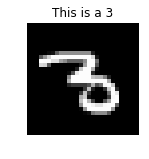

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (2,10)

def show_digit(img, caption='', subplot=None):
    if subplot == None:
        _, (subplot) = plt.subplots(1,1)
    imgr = img.reshape((28,28))
    subplot.axis('off')
    subplot.imshow(imgr, cmap='gray')
    plt.title(caption)

show_digit(train_set[0][30], 'This is a {}'.format(train_set[1][30]))

The SageMaker Python library embodies a number of conventions. It creates subfolders and default destinations for you with conventions you should know. When setting up locations for your work note: 

* All data must reside in S3, with the possible exception of the initial dataset download. Even that should go directly to S3 if possible.
* Training, validation, and testing data should be specified by bucket only. 
* Model output will go into a directory of the format: 
    * lad

In [4]:
%%time
import io
import boto3
from sagemaker.amazon.common import write_numpy_to_dense_tensor

bucket = 'batch-transform' 
bucket_URL = "s3://" + bucket
trainValTest_folder = 'KMexample/data'
training_data_key = trainValTest_folder + "/train.data"
training_data_URL = "s3://" + bucket + "/" + training_data_key
training_data_folder = "s3://" + bucket + "/" + trainValTest_folder
model_URL = bucket_URL + "/KMexample/model"

print('training data will be uploaded to: {}'.format(training_data_URL))

# Convert the training data into the format required by the SageMaker KMeans algorithm
buf = io.BytesIO()
write_numpy_to_dense_tensor(buf, train_set[0], train_set[1])
buf.seek(0)

boto3.resource('s3').Bucket(bucket).Object(training_data_key).upload_fileobj(buf)
print(training_data_folder)

training data will be uploaded to: s3://batch-transform/KMexample/data/train.data
s3://batch-transform/KMexample/data
CPU times: user 8.62 s, sys: 532 ms, total: 9.16 s
Wall time: 8.89 s


In [5]:
from sagemaker import KMeans

kmeans = KMeans(role=role,
                train_instance_count=2,
                train_instance_type='ml.c4.8xlarge',
                output_path=model_URL,
                k=10,
                data_location=training_data_URL)

Use the high-level SDK

In [6]:
%%time

kmeans.fit(kmeans.record_set(train_set[0]))

INFO:sagemaker:Creating training-job with name: kmeans-2018-10-09-18-50-02-168


2018-10-09 18:50:02 Starting - Starting the training job...
Launching requested ML instances......
Preparing the instances for training......
2018-10-09 18:52:18 Downloading - Downloading input data
2018-10-09 18:52:33 Training - Downloading the training image..
Docker entrypoint called with argument(s): train
[10/09/2018 18:52:38 INFO 139717838534464] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_tol': u'0.0001', u'local_lloyd_max_iter': u'300', u'_disable_wait_to_read': u'false', u'extra_center_factor': u'auto', u'eval_metrics': u'["msd"]', u'_num_kv_servers': u'1', u'mini_batch_size': u'5000', u'half_life_time_size': u'0', u'_num_slices': u'1'}
[10/09/2018


2018-10-09 18:52:43 Uploading - Uploading generated training model
2018-10-09 18:52:49 Completed - Training job completed
Billable seconds: 62
CPU times: user 7.61 s, sys: 388 ms, total: 8 s
Wall time: 3min 21s


In [7]:
kmeans.latest_training_job.job_name
modelURL = '{}/{}/output/model.tar.gz'.format(model_URL, kmeans.latest_training_job.job_name)
modelURL

's3://batch-transform/KMexample/model/kmeans-2018-10-09-18-50-02-168/output/model.tar.gz'

In [8]:
sagemaker = boto3.client('sagemaker')
from sagemaker.amazon.amazon_estimator import get_image_uri
image = get_image_uri(boto3.Session().region_name, 'kmeans')

kmeans_hosting_container = {
    'Image': image,
    'ModelDataUrl': modelURL
}

In [9]:
kmeans_hosting_container

{'Image': '174872318107.dkr.ecr.us-west-2.amazonaws.com/kmeans:1',
 'ModelDataUrl': 's3://batch-transform/KMexample/model/kmeans-2018-10-09-18-50-02-168/output/model.tar.gz'}

For Lambda we need to know the name of the model. Here we use kmeans.latest_training_job.job_name, but we won't have that in lambda. It will need to be passed as an event. 

In [10]:
create_model_response = sagemaker.create_model(
    ModelName=kmeans.latest_training_job.job_name,
    ExecutionRoleArn=role,
    PrimaryContainer=kmeans_hosting_container)

# Lambda part
The model is trained and in place. Now we need to call batch transform to call inference. 1st we'll extract a sample image.

In [12]:
import sagemaker

model_name = kmeans.latest_training_job.job_name

bucket = 'batch-transform' 
validation_file = 'validation_data.csv'
validation_key = 'KMexample/data/' + validation_file

prediction_folder = 'KMexample/prediction/'
prediction_key = prediction_folder + validation_file + ".out"

### Convert the validation set numpy array to a csv file and upload to s3
numpy.savetxt(validation_file, valid_set[0], delimiter=',', fmt='%g')

s3_client = boto3.client('s3')
s3_client.upload_file(validation_file, bucket, validation_key)

In [13]:
input_URL = 's3://{}/{}'.format(bucket, validation_key)
output_URL = 's3://{}/{}'.format(bucket, prediction_folder)
print(input_URL)
print(output_URL)

s3://batch-transform/KMexample/data/validation_data.csv
s3://batch-transform/KMexample/prediction/


In [14]:
# Initialize the transformer object
transformer =sagemaker.transformer.Transformer(
    base_transform_job_name='Batch-Transform',
    model_name=model_name,
    instance_count=1,
    instance_type='ml.c4.xlarge',
    output_path=output_URL
    )

CPU times: user 24 ms, sys: 0 ns, total: 24 ms
Wall time: 27 ms


In [15]:
%%time
# To start a transform job:
transformer.transform(input_URL, content_type='text/csv', split_type='Line')

# Then wait until transform job is completed
transformer.wait()

INFO:sagemaker:Creating transform job with name: Batch-Transform-2018-10-09-18-57-14-787


......................................!
CPU times: user 152 ms, sys: 8 ms, total: 160 ms
Wall time: 3min 12s


In [16]:
# To fetch validation result 
s3_client.download_file(bucket, prediction_key, 'valid-result')
with open('valid-result') as f:
    results = f.readlines()   
print("Sample transform result: {}".format(results[0]))

Sample transform result: {"closest_cluster":3.0,"distance_to_cluster":6.344285011291504}

